# Impact Studies Using SuPy

## Aim

In this tutorial, we aim to perform sensitivity analysis using `supy` in a parallel mode to investigate the impacts on urban climate of

1. surface properties: the physical attributes of land covers (e.g., albedo, water holding capacity, etc.)
2. background climate: longterm meteorological conditions (e.g., air temperature, precipitation, etc.)



### load `supy` and sample dataset

In [1]:
from dask import dataframe as dd
import supy as sp

import pandas as pd
import numpy as np

from time import time


In [2]:
# load sample datasets
df_state_init, df_forcing = sp.load_SampleData()

# by default, two years of forcing data are included;
# to save running time for demonstration, we only use one year in this demo
df_forcing=df_forcing.loc['2012'].iloc[1:]

# perform an example run to get output samples for later use
df_output, df_state_final = sp.run_supy(df_forcing, df_state_init)


2020-07-06 00:35:30,550 - SuPy - INFO - All cache cleared.
2020-07-06 00:35:33,162 - SuPy - INFO - ====================
2020-07-06 00:35:33,163 - SuPy - INFO - Simulation period:
2020-07-06 00:35:33,164 - SuPy - INFO -   Start: 2012-01-01 00:05:00
2020-07-06 00:35:33,164 - SuPy - INFO -   End: 2012-12-31 23:55:00
2020-07-06 00:35:33,165 - SuPy - INFO - 
2020-07-06 00:35:33,166 - SuPy - INFO - No. of grids: 1
2020-07-06 00:35:33,166 - SuPy - INFO - SuPy is running in serial mode
2020-07-06 00:35:46,945 - SuPy - INFO - Execution time: 13.8 s
2020-07-06 00:35:46,946 - SuPy - INFO - ====================



## Surface properties: surface albedo

### Examine the default albedo values loaded from the sample dataset

In [3]:
df_state_init.alb

ind_dim,"(0,)","(1,)","(2,)","(3,)","(4,)","(5,)","(6,)"
grid,,,,,,,
1,0.1,0.12,0.1,0.18,0.21,0.18,0.1


### Copy the initial condition `DataFrame`  to have a *clean slate* for our study

Note: `DataFrame.copy()` defaults to `deepcopy`

In [4]:
df_state_init_test = df_state_init.copy()


### Set the `Bldg` land cover to 100% for this study

In [5]:
df_state_init_test.sfr = 0
df_state_init_test.loc[:, ('sfr', '(1,)')] = 1
df_state_init_test.sfr


ind_dim,"(0,)","(1,)","(2,)","(3,)","(4,)","(5,)","(6,)"
grid,,,,,,,
1,0,1,0,0,0,0,0


### Construct a `df_state_init_x` dataframe to perform  `supy` simulations with specified albedo

In [6]:
# create a `df_state_init_x` with different surface properties
n_test = 48
list_alb_test = np.linspace(0.1, 0.8, n_test).round(2)
df_state_init_x = df_state_init_test.append(
    [df_state_init_test]*(n_test-1), ignore_index=True)

# here we modify surface albedo
df_state_init_x.loc[:, ('alb', '(1,)')] = list_alb_test
df_state_init_x.index=df_state_init_x.index.rename('grid')


### Conduct simulations with `supy`

In [7]:
df_forcing_part = df_forcing.loc['2012 01':'2012 07']
df_res_alb_test,df_state_final_x = sp.run_supy(df_forcing_part, df_state_init_x,logging_level=90)

### Examine the simulation results

In [8]:
# choose results of July 2012 for analysis
df_res_alb_test_july = df_res_alb_test.SUEWS.unstack(0).loc["2012 7"]
df_res_alb_T2_stat = df_res_alb_test_july.T2.describe()
df_res_alb_T2_diff = df_res_alb_T2_stat.transform(
    lambda x: x - df_res_alb_T2_stat.iloc[:, 0]
)
df_res_alb_T2_diff.columns = list_alb_test - list_alb_test[0]

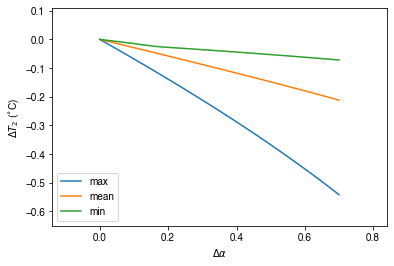

In [9]:
ax_temp_diff = df_res_alb_T2_diff.loc[["max", "mean", "min"]].T.plot()
_ = ax_temp_diff.set_ylabel("$\Delta T_2$ ($^{\circ}}$C)")
_ = ax_temp_diff.set_xlabel(r"$\Delta\alpha$")
ax_temp_diff.margins(x=0.2, y=0.2)

## Background climate: air temperature

### Examine the monthly climatology of air temperature loaded from the sample dataset

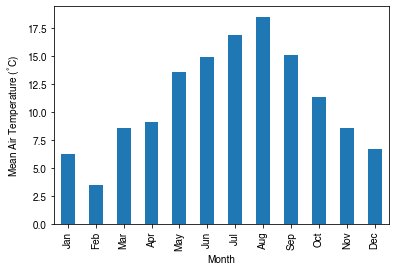

In [10]:
df_plot = df_forcing.Tair.loc["2012"].resample("1m").mean()
ax_temp = df_plot.plot.bar(color="tab:blue")
_ = ax_temp.set_xticklabels(df_plot.index.strftime("%b"))
_ = ax_temp.set_ylabel("Mean Air Temperature ($^\degree$C)")
_ = ax_temp.set_xlabel("Month")

### Construct a function to perform parallel `supy` simulations with specified `diff_airtemp_test`: the difference in air temperature between the one used in simulation and loaded from sample dataset.

<div class="alert alert-info">

Note

forcing data `df_forcing` has different data structure from `df_state_init`; so we need to modify `run_supy_mgrids` to implement a `run_supy_mclims` for different climate scenarios*

</div> 

Let's start the implementation of `run_supy_mclims` with a small problem of four forcing groups (i.e., climate scenarios), where the air temperatures differ from the baseline scenario with a constant bias.

In [11]:
# save loaded sample datasets
df_forcing_part_test = df_forcing.loc['2012 1':'2012 7'].copy()
df_state_init_test = df_state_init.copy()

In [13]:
from dask import delayed
# create a dict with four forcing conditions as a test
n_test = 4
list_TairDiff_test = np.linspace(0., 2, n_test).round(2)
dict_df_forcing_x = {
    tairdiff: df_forcing_part_test.copy()
    for tairdiff in list_TairDiff_test}
for tairdiff in dict_df_forcing_x:
    dict_df_forcing_x[tairdiff].loc[:, 'Tair'] += tairdiff

dd_forcing_x = {
    k: delayed(sp.run_supy)(df, df_state_init_test,logging_level=90)[0]
    for k, df in dict_df_forcing_x.items()}


df_res_tairdiff_test0 = delayed(pd.concat)(
    dd_forcing_x,
    keys=list_TairDiff_test,
    names=['tairdiff'],
)

In [14]:
# test the performance of a parallel run
t0 = time()
df_res_tairdiff_test = df_res_tairdiff_test0\
    .compute(scheduler='threads')\
    .reset_index('grid', drop=True)
t1 = time()
t_par = t1 - t0
print(f'Execution time: {t_par:.2f} s')

Execution time: 29.80 s


In [15]:
# function for multi-climate `run_supy`
# wrapping the above code into one
def run_supy_mclims(df_state_init, dict_df_forcing_mclims):
    dd_forcing_x = {
        k: delayed(sp.run_supy)(df, df_state_init_test,logging_level=90)[0]
        for k, df in dict_df_forcing_x.items()}
    df_output_mclims0 = delayed(pd.concat)(
        dd_forcing_x,
        keys=list(dict_df_forcing_x.keys()),
        names=['clm'],
    ).compute(scheduler='threads')
    df_output_mclims = df_output_mclims0.reset_index('grid', drop=True)

    return df_output_mclims

### Construct `dict_df_forcing_x` with multiple forcing `DataFrame`s

In [17]:
# save loaded sample datasets
df_forcing_part_test = df_forcing.loc['2012 1':'2012 7'].copy()
df_state_init_test = df_state_init.copy()

# create a dict with a number of forcing conditions
n_test = 12 # can be set with a smaller value to save simulation time
list_TairDiff_test = np.linspace(0., 2, n_test).round(2)
dict_df_forcing_x = {
    tairdiff: df_forcing_part_test.copy()
    for tairdiff in list_TairDiff_test}
for tairdiff in dict_df_forcing_x:
    dict_df_forcing_x[tairdiff].loc[:, 'Tair'] += tairdiff

### Perform simulations

In [18]:
# run parallel simulations using `run_supy_mclims`
t0 = time()
df_airtemp_test_x = run_supy_mclims(df_state_init_test, dict_df_forcing_x)
t1 = time()
t_par = t1-t0
print(f'Execution time: {t_par:.2f} s')

Execution time: 183.60 s


### Examine the results

In [19]:
df_airtemp_test = df_airtemp_test_x.SUEWS.unstack(0)
df_temp_diff = df_airtemp_test.T2.transform(lambda x: x - df_airtemp_test.T2[0.0])
df_temp_diff_ana = df_temp_diff.loc["2012 7"]
df_temp_diff_stat = df_temp_diff_ana.describe().loc[["max", "mean", "min"]].T

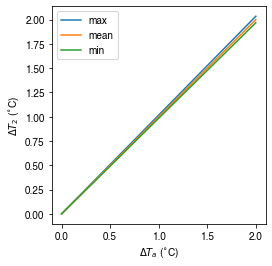

In [20]:
ax_temp_diff_stat=df_temp_diff_stat.plot()
_=ax_temp_diff_stat.set_ylabel('$\\Delta T_2$ ($^{\\circ}}$C)')
_=ax_temp_diff_stat.set_xlabel('$\\Delta T_{a}$ ($^{\\circ}}$C)')
ax_temp_diff_stat.set_aspect('equal')

The $T_{2}$ results indicate the increased $T_{a}$ has different impacts on the $T_{2}$ metrics (minimum, mean and maximum) but all increase linearly with $T_{a}.$ The maximum $T_{2}$ has the stronger response compared to the other metrics.